In [138]:
import pandas as pd
import numpy as np

import os
import re
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow
from keras.optimizers import adam_v2
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pyaudio
import speech_recognition as sr
import wave
import random
import string
import json
import glob

# Language model (Bert)

In [46]:
import speech_recognition as sr 
import pandas as pd
import numpy as np
import torch
from torch import nn
from transformers import BertModel,BertTokenizer
from torch.optim import Adam
from tqdm import tqdm

In [47]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertClassifier()
bert_model.load_state_dict(torch.load('models/bert.pt', map_location=torch.device('cpu')))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [49]:
labels = {
    'joy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'neutral': 4
}
val_dict = dict((v,k) for k,v in labels.items())

In [50]:
def pred_one(model, sentence):
    output_conf_lst = []
    text_input = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    with torch.no_grad():
        mask = text_input['attention_mask'].to(device)
        input_id = text_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)
    if use_cuda:
        conf_score = output.cpu().detach().numpy()
    else:
        conf_score = output.detach().numpy()
    val = output.argmax(dim=1).item()
    return val_dict[val], conf_score

## Ravdess Data

In [ ]:
Ravdess = "input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "input/cremad/"
Tess = "input/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "input/surrey-audiovisual-expressed-emotion-savee/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)
ravdess_directory_list = [x for x in ravdess_directory_list if x != '.DS_Store']
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        if int(part[2]) == 1 or int(part[2]) == 3 or int(part[2]) == 4 or int(part[2]) == 5 or int(part[2]) == 6:
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df.Emotions.replace({1:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,input/ravdess-emotional-speech-audio/audio_spe...
1,fear,input/ravdess-emotional-speech-audio/audio_spe...
2,fear,input/ravdess-emotional-speech-audio/audio_spe...
3,angry,input/ravdess-emotional-speech-audio/audio_spe...
4,sad,input/ravdess-emotional-speech-audio/audio_spe...


## Crema Data

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    part=file.split('_')
    if part[2] == 'SAD':
        file_path.append(Crema + file)
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_path.append(Crema + file)
        file_emotion.append('angry')
    elif part[2] == 'FEA':
        file_path.append(Crema + file)
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_path.append(Crema + file)
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_path.append(Crema + file)
        file_emotion.append('neutral')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,input/cremad/1022_ITS_ANG_XX.wav
1,angry,input/cremad/1037_ITS_ANG_XX.wav
2,neutral,input/cremad/1060_ITS_NEU_XX.wav
3,neutral,input/cremad/1075_ITS_NEU_XX.wav
4,sad,input/cremad/1078_IWL_SAD_XX.wav


##  TESS data

In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'neutral' or part == 'fear' or part =='sad' or part == 'angry' or part == 'happy':
            file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,happy,input/TESS Toronto emotional speech set data/T...
1,happy,input/TESS Toronto emotional speech set data/T...
2,happy,input/TESS Toronto emotional speech set data/T...
3,happy,input/TESS Toronto emotional speech set data/T...
4,happy,input/TESS Toronto emotional speech set data/T...


## savee

In [6]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    #file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_path.append(Savee + file)
        file_emotion.append('angry')
    elif ele=='f':
        file_path.append(Savee + file)
        file_emotion.append('fear')
    elif ele=='h':
        file_path.append(Savee + file)
        file_emotion.append('happy')
    elif ele=='n':
        file_path.append(Savee + file)
        file_emotion.append('neutral')
    elif ele=='sa':
        file_path.append(Savee + file)
        file_emotion.append('sad')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,sad,input/surrey-audiovisual-expressed-emotion-sav...
1,sad,input/surrey-audiovisual-expressed-emotion-sav...
2,neutral,input/surrey-audiovisual-expressed-emotion-sav...
3,neutral,input/surrey-audiovisual-expressed-emotion-sav...
4,neutral,input/surrey-audiovisual-expressed-emotion-sav...


In [10]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)

##  Meld dataset

In [11]:
meld_train_upstream = pd.read_csv('input/meld/dev/dev_sent_emo.csv')
meld_train_upstream = meld_train_upstream[meld_train_upstream['Emotion'].apply(lambda x: x in ['neutral', 'joy', 'anger', 'sadness', 'fear'])]
meld_train_upstream['Path'] = meld_train_upstream[['Dialogue_ID', 'Utterance_ID']].apply(lambda x: 'input/meld/dev/dia' + str(x.iloc[0]) + '_utt' + str(x.iloc[1]) + '.wav', axis = 1)
matching_lst = glob.glob("input/meld/dev/*.wav")
meld_train_upstream = meld_train_upstream[meld_train_upstream['Path'].apply(lambda x: True if x in matching_lst else False)]
num_to_samp = meld_train_upstream['Emotion'].value_counts().iloc[-1]
meld_train_upstream_df = pd.DataFrame()
for mood in ['neutral', 'joy', 'anger', 'sadness', 'fear']:
    data_samp = meld_train_upstream[meld_train_upstream['Emotion'] == mood].sample(num_to_samp)
    meld_train_upstream_df = meld_train_upstream_df.append(data_samp)

meld_train_upstream_df = meld_train_upstream_df[['Emotion','Path']]
meld_train_upstream_df = meld_train_upstream_df.rename(columns = {'Emotion': 'Emotions'})
emo_dct = {'anger':'angry',
'sadness':'sad',
'joy':'happy',
}
meld_train_upstream_df['Emotions'] = meld_train_upstream_df['Emotions'].apply(lambda x: emo_dct[x] if x in ['anger','sadness', 'joy'] else x)

In [12]:
meld_train_upstream_df['Emotions'].value_counts()

neutral    40
happy      40
angry      40
sad        40
fear       40
Name: Emotions, dtype: int64

In [13]:
data_path = data_path.append(meld_train_upstream_df)
data_path = data_path.reset_index(drop = True)

In [14]:
meld_train_downstream = pd.read_csv('input/meld/train/train_sent_emo.csv')
meld_train_downstream = meld_train_downstream[meld_train_downstream['Emotion'].apply(lambda x: x in ['neutral', 'joy', 'anger', 'sadness', 'fear'])]

In [15]:
meld_train_downstream['Emotion'].value_counts()

neutral    4710
joy        1743
anger      1109
sadness     683
fear        268
Name: Emotion, dtype: int64

In [16]:
meld_train_downstream = pd.read_csv('input/meld/train/train_sent_emo.csv')
meld_train_downstream = meld_train_downstream[meld_train_downstream['Emotion'].apply(lambda x: x in ['neutral', 'joy', 'anger', 'sadness', 'fear'])]
meld_train_downstream['Path'] = meld_train_downstream[['Dialogue_ID', 'Utterance_ID']].apply(lambda x: 'input/meld/train/dia' + str(x.iloc[0]) + '_utt' + str(x.iloc[1]) + '.wav', axis = 1)
matching_lst = glob.glob("input/meld/train/*.wav")
meld_train_downstream = meld_train_downstream[meld_train_downstream['Path'].apply(lambda x: True if x in matching_lst else False)]
num_to_samp = meld_train_downstream['Emotion'].value_counts().iloc[-1]
meld_train_donwstream_df = pd.DataFrame()
for mood in ['neutral', 'joy', 'anger', 'sadness', 'fear']:
    data_samp = meld_train_downstream[meld_train_downstream['Emotion'] == mood].sample(num_to_samp)
    meld_train_donwstream_df = meld_train_donwstream_df.append(data_samp)

meld_train_donwstream_df = meld_train_donwstream_df[['Emotion','Path','Utterance']]
meld_train_donwstream_df = meld_train_donwstream_df.rename(columns = {'Emotion': 'Emotions','Utterance':'text'})

In [17]:
meld_train_donwstream_df

,Emotions,Path,text
7893,neutral,input/meld/train/dia834_utt12.wav,Me neither.
38,neutral,input/meld/train/dia3_utt4.wav,"Look, 'My vessel so empty with nothing inside."
8834,neutral,input/meld/train/dia929_utt2.wav,We will.
6522,neutral,input/meld/train/dia678_utt6.wav,This is Monica.
2873,neutral,input/meld/train/dia304_utt3.wav,"Oh, just this! Yknow what its my fault real..."
...,...,...,...
577,fear,input/meld/train/dia54_utt12.wav,I was scared of telling you.
8011,fear,input/meld/train/dia844_utt6.wav,"Division, between people in white coats and pe..."
578,fear,input/meld/train/dia54_utt13.wav,"Well Id be scared of them, but all right."
6221,fear,input/meld/train/dia654_utt2.wav,"And I will cook anything you want in here , an..."


In [18]:
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,input/ravdess-emotional-speech-audio/audio_spe...
1,fear,input/ravdess-emotional-speech-audio/audio_spe...
2,fear,input/ravdess-emotional-speech-audio/audio_spe...
3,angry,input/ravdess-emotional-speech-audio/audio_spe...
4,sad,input/ravdess-emotional-speech-audio/audio_spe...


## Data Visualisation

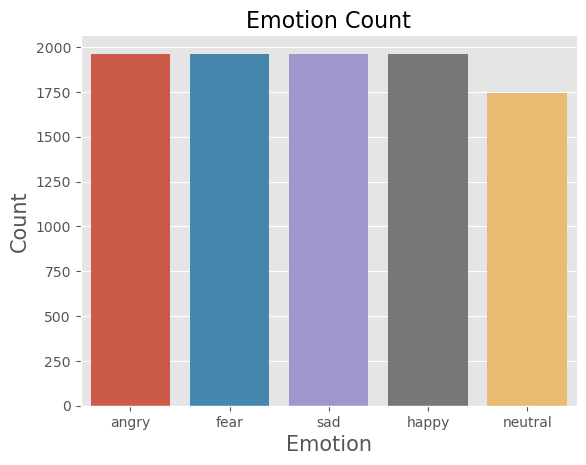

In [465]:
plt.title('Emotion Count', size=16)
sns.countplot(x = data_path['Emotions'])
plt.ylabel('Count', size=15)
plt.xlabel('Emotion', size=15)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [488]:
def spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(13, 4))
    plt.title('Spectrogram: {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, y_axis='hz', x_axis='time')   
    plt.colorbar()
def waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot: {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

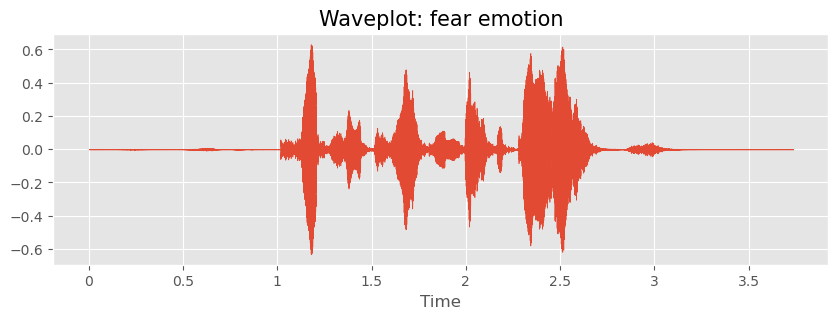

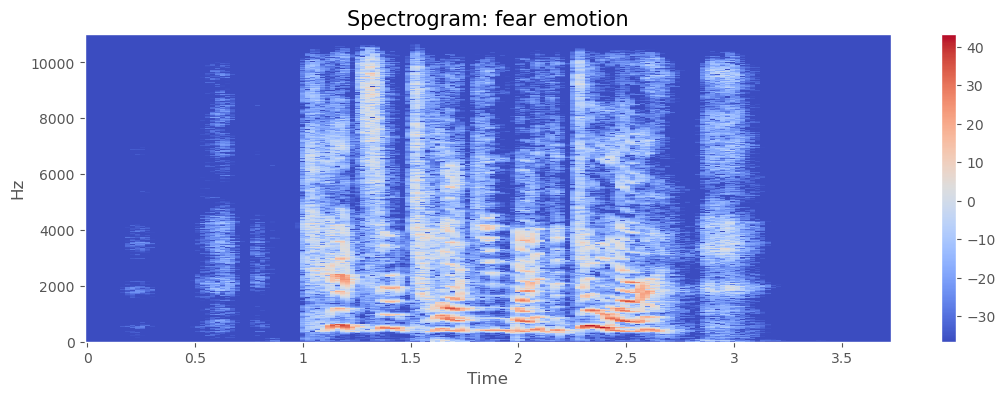

In [489]:
path = np.array(data_path.Path[data_path.Emotions=='fear'])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [25]:
def stretch(audio_data, rate=0.7):
    return librosa.effects.time_stretch(audio_data, rate)
def noise(audio_data):
    noise_amp = 0.02*np.random.uniform()*np.amax(audio_data)
    audio_data = audio_data + noise_amp*np.random.normal(size=audio_data.shape[0])
    return audio_data
def pitch(audio_data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(audio_data, sampling_rate, pitch_factor)
def shift(audio_data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(audio_data, shift_range)
# sample one path to check
path = np.array(data_path.Path)[2]
data, sample_rate = librosa.load(path)

#### 1. Original Audio

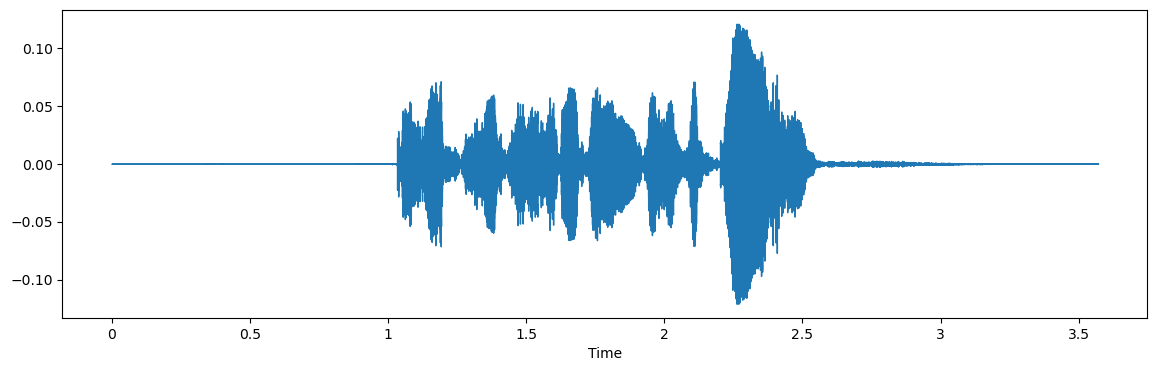

In [26]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injected

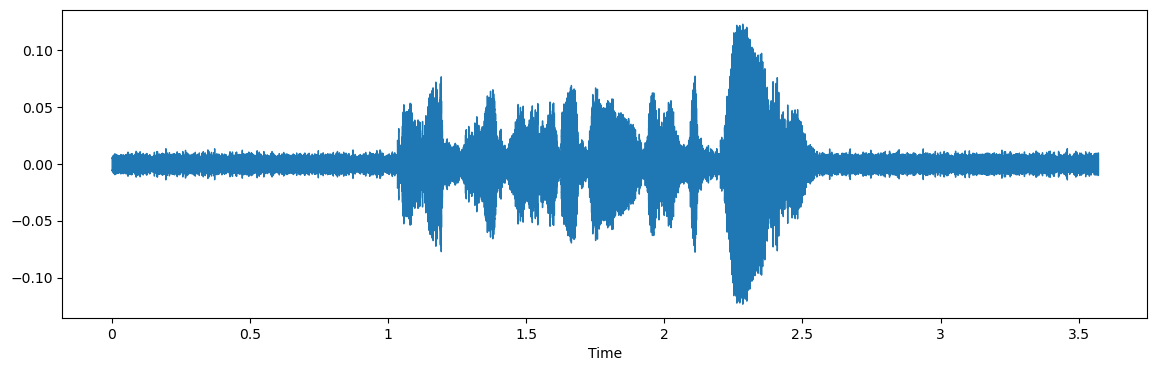

In [27]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretched

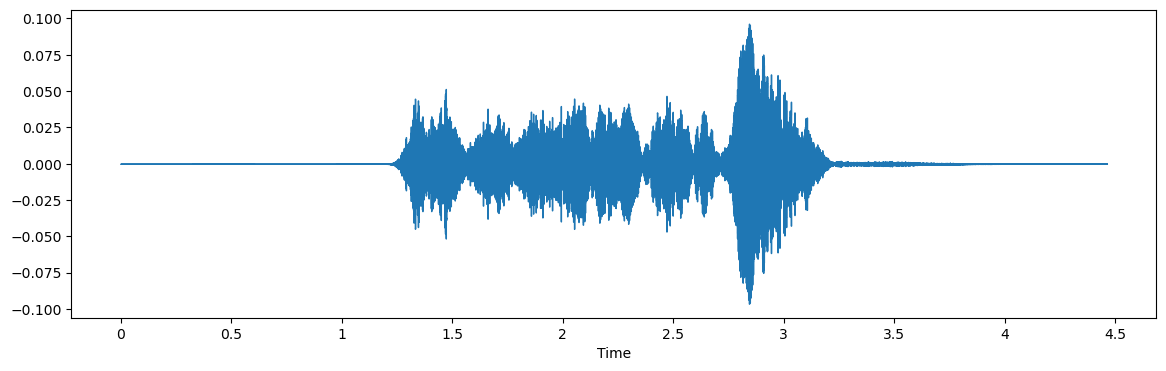

In [28]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifted

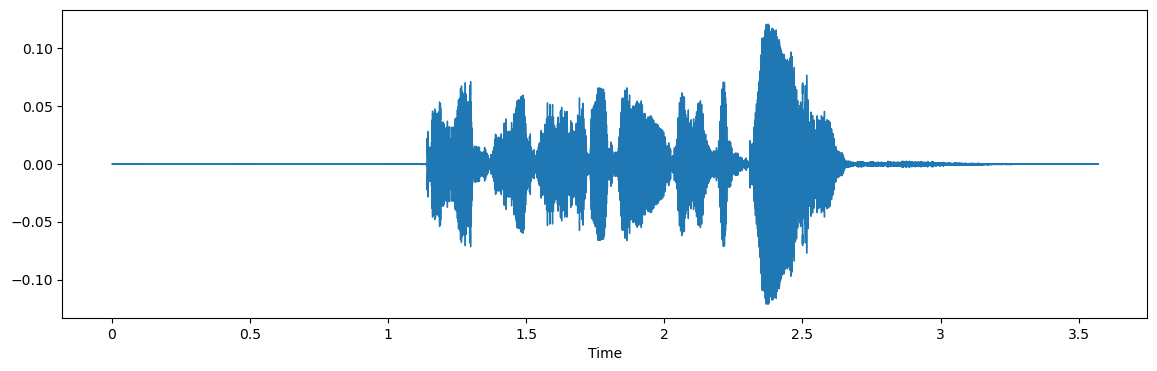

In [29]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

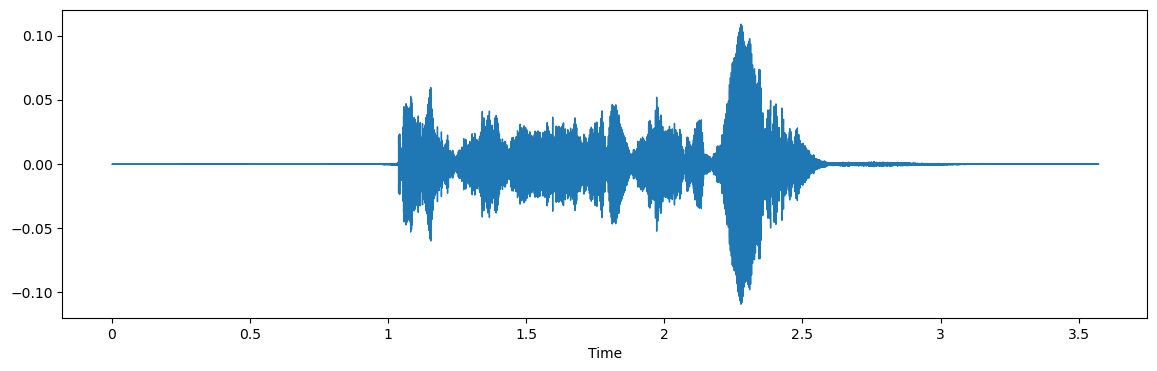

In [30]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- MelSpectogram to train our model.
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value

In [31]:
def extract_features(data):
    result = np.array([]) 
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    res1 = extract_features(data)
    result = np.array(res1)
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path['Path'], ['data_path.Emotions']):
    try:
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            Y.append(emotion)
    except:
        pass

In [ ]:
len(X), len(Y), data_path.Path.shape

In [ ]:
data_path

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

In [146]:
#read in past augmented data
Features = pd.read_csv('features.csv')

In [147]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.192464,0.516620,0.464575,0.484971,0.538362,0.500001,0.598386,0.544128,0.527744,0.602508,...,0.006685,0.004040,0.004858,0.004599,0.005219,0.003749,0.000923,0.000175,1.708295e-06,angry
1,0.351865,0.697865,0.683665,0.695280,0.726990,0.702039,0.713379,0.629169,0.655331,0.720986,...,0.010892,0.008360,0.008668,0.008752,0.009278,0.007688,0.004980,0.003960,3.846523e-03,angry
2,0.222465,0.623192,0.508885,0.473313,0.479617,0.492326,0.520755,0.625966,0.541471,0.545651,...,0.003624,0.002221,0.000976,0.000675,0.000999,0.000515,0.000244,0.000016,5.332614e-08,angry
3,0.184814,0.552939,0.514264,0.477355,0.408057,0.359502,0.394911,0.405739,0.433439,0.497811,...,0.002602,0.002953,0.003854,0.003141,0.002715,0.001565,0.000508,0.000056,7.527195e-07,fear
4,0.321814,0.739344,0.755934,0.745128,0.694337,0.671079,0.615393,0.576950,0.589412,0.620108,...,0.003246,0.003729,0.004610,0.003892,0.003412,0.002355,0.001262,0.000860,7.607853e-04,fear


## Data Preparation for the model

In [33]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

## Audio model

In [38]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Metal device set to: Apple M1 Pro


2022-12-04 02:53:22.269691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 02:53:22.269867: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [39]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), callbacks=[rlrp])

2022-12-04 02:53:31.263908: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-04 02:53:31.264408: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-12-04 02:53:38.679822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - ETA: 0s - loss: 1.4509 - accuracy: 0.3355

2022-12-04 02:53:46.197505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 16s 21ms/step - loss: 1.4506 - accuracy: 0.3356 - val_loss: 1.1774 - val_accuracy: 0.4774
Epoch 2/30
338/338 [==============================] - 7s 20ms/step - loss: 1.2032 - accuracy: 0.4745 - val_loss: 1.0898 - val_accuracy: 0.5316
Epoch 3/30
338/338 [==============================] - 7s 20ms/step - loss: 1.1427 - accuracy: 0.5088 - val_loss: 1.1806 - val_accuracy: 0.4770
Epoch 4/30
338/338 [==============================] - 7s 20ms/step - loss: 1.1250 - accuracy: 0.5177 - val_loss: 1.0434 - val_accuracy: 0.5325
Epoch 5/30
338/338 [==============================] - 7s 20ms/step - loss: 1.0609 - accuracy: 0.5527 - val_loss: 0.9758 - val_accuracy: 0.5785
Epoch 6/30
338/338 [==============================] - 7s 20ms/step - loss: 1.0254 - accuracy: 0.5612 - val_loss: 0.9741 - val_accuracy: 0.5843
Epoch 7/30
338/338 [==============================] - 7s 20ms/step - loss: 1.0209 - accuracy: 0.5666 - val_loss: 0.9461 - val_accuracy: 0.5976
Epoch 8/3

225/225 [==============================] - 2s 7ms/step - loss: 0.8851 - accuracy: 0.6555
Accuracy of our model on test data :  65.55416584014893 %


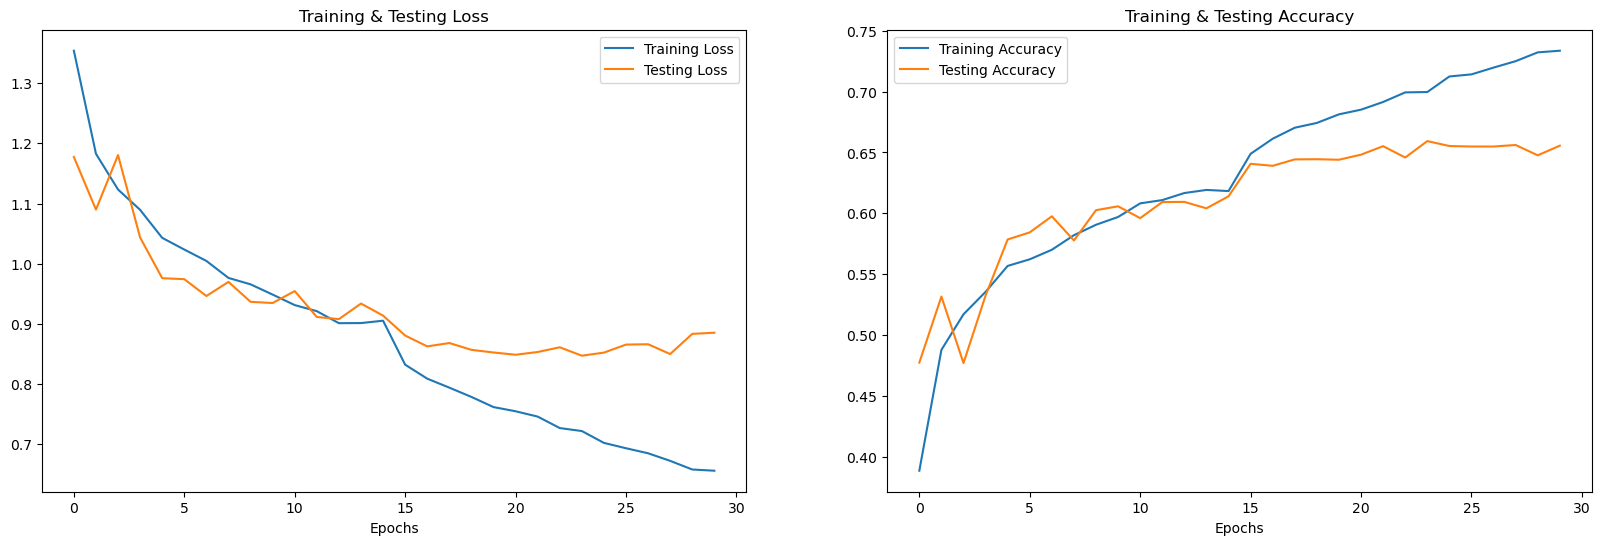

In [40]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Acc')
ax[1].plot(epochs , test_acc , label = 'Testing Acc')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [41]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

2022-12-04 02:58:33.472693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [42]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,sad,sad
2,fear,sad
3,fear,happy
4,happy,happy
5,fear,sad
6,fear,happy
7,sad,sad
8,angry,angry
9,neutral,sad


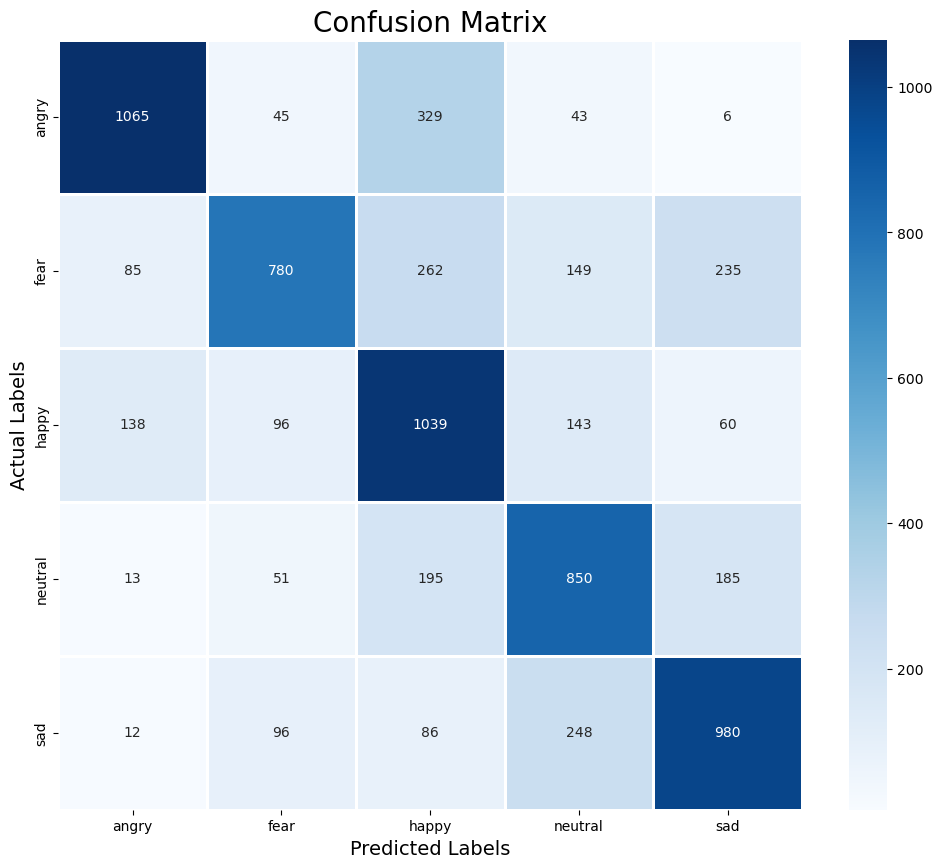

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.81      0.72      0.76      1488
        fear       0.73      0.52      0.60      1511
       happy       0.54      0.70      0.61      1476
     neutral       0.59      0.66      0.62      1294
         sad       0.67      0.69      0.68      1422

    accuracy                           0.66      7191
   macro avg       0.67      0.66      0.66      7191
weighted avg       0.67      0.66      0.66      7191



# Direct audio feed-in

In [68]:
chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 44100  # Record at 44100 samples per second
seconds = 3
letters = string.ascii_lowercase

filename = 'wav_folder/' + ''.join(random.choice(letters) for i in range(10)) + '.wav'

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

Recording
Finished recording


In [69]:
import speech_recognition as sr
def myCommand():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        audio = r.listen(source, phrase_time_limit = 5)  
    try:
        command = r.recognize_google(audio).lower()
        print("you said: " + command)
        
    except sr.UnknownValueError:
        print("Sorry, Cant understand, Please say again")
        command = myCommand()
    return command

In [72]:
r = sr.Recognizer()
with sr.AudioFile(filename) as source:
    # listen for the data (load audio to memory)
    audio_data = r.record(source)
    # recognize (convert from speech to text)
    text = r.recognize_sphinx(audio_data)
    print(text)

to do so wonderfully


In [73]:
X_test_lst= []

feature = get_features(filename)
for ele in feature:
    X_test_lst.append(ele)
    # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.

X_test_lst = np.array(X_test_lst)

In [74]:
X_test_lst = scaler.transform(X_test_lst)
X_test_lst = np.expand_dims(X_test_lst, axis=2)

In [75]:
pred_test

array([[3.77757251e-02, 8.50217521e-01, 8.56990442e-02, 6.53838506e-03,
        1.97694469e-02],
       [1.06911684e-05, 4.81176525e-02, 8.43790302e-04, 1.78331003e-01,
        7.72696912e-01],
       [1.68545563e-02, 6.20819151e-01, 3.47821534e-01, 1.72522990e-03,
        1.27795460e-02],
       ...,
       [8.07138453e-11, 1.19942359e-12, 1.26111521e-09, 1.00000000e+00,
        2.17273075e-11],
       [1.23166312e-02, 6.83903933e-01, 1.76247135e-01, 1.66103654e-02,
        1.10921964e-01],
       [6.44572377e-01, 3.41595411e-02, 3.19370240e-01, 1.44068280e-03,
        4.57210961e-04]], dtype=float32)

In [76]:
# predicting on test data.
pred_test = model.predict(X_test_lst)
pred_test = np.array([pred_test[i:i+ 2].mean(axis = 0) for i in range(len(pred_test)//3)])
y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)

In [77]:
y_pred

array([['happy']], dtype=object)

In [78]:
#bert
bert_pred = pred_one(bert_model, text)
bert_pred

('joy',
 array([[5.2364936, 0.       , 0.       , 0.       , 0.       ]],
       dtype=float32))

In [79]:
labels

{'joy': 0, 'sadness': 1, 'fear': 2, 'anger': 3, 'neutral': 4}

# Import and train downstream model

In [184]:
base_path = "/Users/sung-linchang/Documents/github/nlp-text-emotion/text_tone_data/"

In [185]:
name_paths = ['yifei','asher', 'harold', 'jackson','arthur']

In [490]:
path_lst = []
mood_lst = []
text_lst = []
for name_path in name_paths:
    os.chdir(base_path + name_path)
    with open(base_path + name_path + '/' + name_path + '.json') as json_file:
        json_file = json.load(json_file)
#     for path in glob.glob("*.wav"):
#         temp_path = base_path + name_path + '/' + path
#         if re.search('[a-zA-Z][-|_]0[-|_]', temp_path):
#             path_lst += [temp_path]
#             mood_lst += [json_file[path.replace('-','_')][1]]
#             text_lst += [json_file[path.replace('-','_')][0]]
        
    path_lst += [base_path + name_path + '/' + path for path in glob.glob("*.wav")]
    path_lst_iter = [path.replace('-','_') for path in glob.glob("*.wav")]
    mood_lst += [json_file[key][1] for key in path_lst_iter]
    text_lst += [json_file[key][0] for key in path_lst_iter]

In [491]:
#change directory back to base
os.chdir("/Users/sung-linchang/Documents/github/nlp-text-emotion/")

In [492]:
our_df = pd.DataFrame()
our_df['Path'] = path_lst
our_df['Emotions'] = mood_lst
our_df['text'] = text_lst

In [493]:
# our_df = our_df.append(meld_train_donwstream_df)

In [494]:
#override
# our_df = meld_train_donwstream_df.copy()

In [495]:
our_df = our_df.reset_index(drop = True)

In [496]:
our_df

,Path,Emotions,text
0,/Users/sung-linchang/Documents/github/nlp-text...,joy,I feel really special and important
1,/Users/sung-linchang/Documents/github/nlp-text...,fear,I feel very strange today
2,/Users/sung-linchang/Documents/github/nlp-text...,fear,I remember feeling acutely distressed for a fe...
3,/Users/sung-linchang/Documents/github/nlp-text...,joy,I feel very happy and excited since i learned ...
4,/Users/sung-linchang/Documents/github/nlp-text...,joy,I love this song and it always makes me feel h...
...,...,...,...
95,/Users/sung-linchang/Documents/github/nlp-text...,anger,Why did you do that to him? Answer me right now!
96,/Users/sung-linchang/Documents/github/nlp-text...,neutral,Hey! Did you grab the newspaper?
97,/Users/sung-linchang/Documents/github/nlp-text...,neutral,Mitochondria is the powerhouse of a cell.
98,/Users/sung-linchang/Documents/github/nlp-text...,neutral,"I am going to the grocery store, would you lik..."


In [497]:
our_df.shape

(100, 3)

In [385]:
our_df['Emotions'].unique()

array(['neutral', 'joy', 'anger', 'sadness', 'fear'], dtype=object)

In [386]:
X, Y = [], []
i = 0
i_to_skip = []
for path, emotion in zip(our_df['Path'], our_df['Emotions']):
    try:
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            Y.append(emotion)
    except:
        i_to_skip += [i]
    i += 1

In [389]:
features_our = pd.DataFrame(X)
features_our['labels'] = Y
features_our.to_csv('features_our.csv', index=False)
features_our.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.059692,0.757641,0.527395,0.566060,0.468022,0.428034,0.384286,0.338837,0.346113,0.403757,...,1.721870e-05,1.613753e-05,1.529408e-05,1.460790e-05,1.405429e-05,1.362474e-05,1.329276e-05,1.306387e-05,1.291890e-05,neutral
1,0.140747,0.742457,0.531501,0.563025,0.468364,0.426682,0.382331,0.337010,0.344342,0.405845,...,2.557338e-05,2.820420e-05,3.015300e-05,2.955693e-05,2.552082e-05,3.158295e-05,2.229834e-05,2.637727e-05,3.318482e-05,neutral
2,0.035254,0.644942,0.492942,0.527329,0.449567,0.406686,0.378590,0.337093,0.316062,0.393763,...,1.526313e-05,1.402364e-05,1.311537e-05,1.243474e-05,1.168312e-05,9.848255e-06,6.570694e-06,3.776780e-06,2.680012e-06,neutral
3,0.147008,0.409237,0.416195,0.420233,0.548421,0.582013,0.603477,0.588525,0.470243,0.509508,...,1.295272e-08,1.214805e-08,1.151551e-08,1.099751e-08,1.057844e-08,1.025238e-08,1.000006e-08,9.825628e-09,9.715414e-09,neutral
4,0.230413,0.536195,0.542260,0.555803,0.666478,0.677639,0.651179,0.635215,0.539520,0.576044,...,1.660163e-03,1.655133e-03,1.648101e-03,1.731401e-03,1.813901e-03,1.757951e-03,1.811598e-03,1.752312e-03,1.682508e-03,neutral


In [390]:
features_our = pd.read_csv('features_our.csv')

In [391]:
features_our.shape

(3906, 163)

In [392]:
X_our = features_our.iloc[: ,:-1].values
Y_our = features_our['labels'].values

In [393]:
X_our_temp = []
count = 0
for i in range(len(X_our)//3):
    i += count
    X_our_temp += [X_our[i: i+ 3]]
    count += 2
X_our_temp = np.array(X_our_temp)

In [394]:
encoder = OneHotEncoder()
Y_our = encoder.fit_transform(np.array(Y_our).reshape(-1,1)).toarray()

In [395]:
Y_our_temp = []
count = 0
for i in range(len(Y_our)//3):
    i += count
    Y_our_temp += [Y_our[i: i+ 3]]
    count += 2
Y_our_temp = np.array(Y_our_temp)

In [396]:
our_df = our_df.drop(i_to_skip, axis= 0)

In [398]:
nlp_df = our_df[['Emotions','text']]
X_nlp = nlp_df['text'].values
Y_nlp = nlp_df['Emotions'].values
x_audio_train, x_audio_test, y_audio_train, y_audio_test = train_test_split(X_our_temp, Y_our_temp, random_state=0)
x_nlp_train, x_nlp_test, y_nlp_train, y_nlp_test = train_test_split(X_nlp, Y_nlp, random_state=0)
x_audio_train.shape, y_audio_train.shape, x_audio_test.shape, y_audio_test.shape

((976, 3, 162), (976, 3, 5), (326, 3, 162), (326, 3, 5))

In [399]:
x_audio_train = x_audio_train.reshape(-1, x_audio_train.shape[-1])
x_audio_test = x_audio_test.reshape(-1, x_audio_test.shape[-1])
y_audio_train = y_audio_train.reshape(-1, y_audio_train.shape[-1])
y_audio_test = y_audio_test.reshape(-1, y_audio_test.shape[-1])
x_audio_train.shape, y_audio_train.shape, x_audio_test.shape, y_audio_test.shape

((2928, 162), (2928, 5), (978, 162), (978, 5))

In [400]:
x_nlp_train.shape, y_nlp_train.shape, x_nlp_test.shape, y_nlp_test.shape

((976,), (976,), (326,), (326,))

In [401]:
scaler = StandardScaler()
x_audio_train = scaler.fit_transform(x_audio_train)
x_audio_test = scaler.transform(x_audio_test)
x_audio_train.shape, y_audio_train.shape, x_audio_test.shape, y_audio_test.shape

((2928, 162), (2928, 5), (978, 162), (978, 5))

In [402]:
x_audio_train = np.expand_dims(x_audio_train, axis=2)
x_audio_test = np.expand_dims(x_audio_test, axis=2)
x_audio_train.shape, y_audio_train.shape, x_audio_test.shape, y_audio_test.shape

((2928, 162, 1), (2928, 5), (978, 162, 1), (978, 5))

In [403]:
x_audio_train_pred = model.predict(x_audio_train)
x_audio_test_pred = model.predict(x_audio_test)
y_audio_train_pred = encoder.inverse_transform(x_audio_train_pred)
y_audio_test_pred = encoder.inverse_transform(x_audio_test_pred)
y_audio_train_actual = encoder.inverse_transform(y_audio_train)
y_audio_test_actual = encoder.inverse_transform(y_audio_test)

In [404]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_audio_train_pred.flatten()
df['Actual Labels'] = y_audio_train_actual.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,anger,sadness
1,joy,sadness
2,neutral,sadness
3,sadness,sadness
4,sadness,sadness
5,sadness,sadness
6,joy,sadness
7,sadness,sadness
8,joy,sadness
9,fear,sadness


In [405]:
#check only original data
df_temp = df.iloc[[i for i in range(0, len(df), 4)]]
# 1/5 = 0.2 The model is inaccurate without context
df_temp.apply(lambda x: x[0] == x[1], axis = 1).mean()

0.22404371584699453

In [406]:
# 1/5 = 0.2 The model is inaccurate without context
df.apply(lambda x: x[0] == x[1], axis = 1).mean()

0.2271174863387978

In [407]:
# predicting on text.
nlp_train_pred_label = []
nlp_test_pred_label = []
nlp_train_pred_weight = []
nlp_test_pred_weight = []

for sent in x_nlp_train:
    pred_label, weights = pred_one(bert_model, sent)
    nlp_train_pred_label += [pred_label]
    nlp_train_pred_weight += [weights]

for sent in x_nlp_train:
    pred_label, weights = pred_one(bert_model, sent)
    nlp_test_pred_label += [pred_label]
    nlp_test_pred_weight += [weights]

In [408]:
upstream_text_df = pd.DataFrame()
upstream_text_df['pred_label'] = nlp_train_pred_label
upstream_text_df['actual_label'] = y_nlp_train
upstream_text_df.head()

,pred_label,actual_label
0,fear,sadness
1,sadness,sadness
2,neutral,sadness
3,neutral,sadness
4,neutral,neutral


In [409]:
upstream_text_df.apply(lambda x: x[0] == x[1], axis = 1).mean()

0.39959016393442626

# downstream model training

In [410]:
x_downstream_train = []
count = 0
for i in range(len(x_audio_train_pred)//3):
    nlp_current_iter = nlp_train_pred_weight[i]
    i += count
    x_downstream_train += [np.append(x_audio_train_pred[i: i + 3].flatten(), nlp_current_iter)]
    count += 2
x_downstream_train = np.array(x_downstream_train)

In [413]:
x_downstream_test = []
count = 0
for i in range(len(x_audio_test_pred)//3):
    nlp_current_iter = nlp_test_pred_weight[i]
    i += count
    x_downstream_test += [np.append(x_audio_test_pred[i: i + 3].flatten(), nlp_current_iter)]
    count += 2
x_downstream_test = np.array(x_downstream_test)

In [414]:
len(x_downstream_test), len(y_nlp_test)

(326, 326)

In [415]:
# scaling our data with sklearn's Standard scaler
donwstream_scaler = StandardScaler()
x_downstream_test = donwstream_scaler.fit_transform(x_downstream_test)

In [416]:
lb = LabelBinarizer()
y_downstream_train = lb.fit_transform(y_nlp_train)
y_downstream_test = lb.transform(y_nlp_test)

In [417]:
x_downstream_test

array([[ 0.94216645, -0.4997248 , -0.03007269, ...,  0.41041553,
         0.22812614, -0.44316822],
       [-0.8253545 , -0.8492293 , -0.9485064 , ..., -0.9019148 ,
        -0.80950844, -0.5039872 ],
       [-0.8250387 ,  2.0880206 , -0.89444953, ..., -0.8011095 ,
        -0.80950844,  1.3383542 ],
       ...,
       [ 1.4726255 , -0.46526352, -0.83560497, ...,  0.5236742 ,
         0.9958381 , -0.613901  ],
       [-0.5026081 , -0.23353061, -0.37517548, ..., -0.9019148 ,
        -0.80950844, -0.12179483],
       [ 0.8940858 , -0.5244136 ,  0.09815741, ..., -0.9019148 ,
        -0.80950844,  1.7952551 ]], dtype=float32)

# grid search

In [418]:
def train_test_model(hparams):
    downstream_model = Sequential()
    downstream_model.add(Dense(15, input_shape=(20,), activation=hparams['activations']))
    downstream_model.add(Dropout(hparams['dropouts']))
    downstream_model.add(Dense(7, activation=hparams['activations'], kernel_regularizer=regularizers.L1(hparams['l2s'])))
    downstream_model.add(Dense(5, activation="softmax"))
    #compile model
    downstream_model.compile(loss="categorical_crossentropy", optimizer=hparams['optimizers'],
    metrics=["accuracy"])
    history = downstream_model.fit(x_downstream_train, y_downstream_train, validation_data=(x_downstream_test, y_downstream_test),
        epochs=hparams['epochs'], batch_size=10, )
    
    return history.history["val_accuracy"][-1]

In [282]:
optimizers = [0.001, 0.0001]
activations = ['sigmoid', 'relu']
epochs = [10,30,50]
dropouts = [1,2,3]
l2s = [0.1,0.01,0.001]

In [419]:
session_num = 0
performance_dct = {}
for lr in optimizers:
    for activation in activations:
        for epoch in epochs:
            for dropout_rate in dropouts:
                for l2 in l2s:
                    hparams = {
                    'optimizers': adam_v2.Adam(lr = lr),
                    'epochs': epoch,
                    'dropouts': dropout_rate,
                    'activations': activation,
                    'l1s': l2
                    }
                    
                    performance_dct[str(hparams)] = train_test_model(hparams)
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print('accuracy' + str(performance_dct[str(hparams)]))
                    session_num += 1
                    

In [475]:
# define the 20-15-10-5 architecture using Keras
downstream_model = Sequential()
downstream_model.add(Dense(15, input_shape=(20,), activation="sigmoid"))
downstream_model.add(Dense(10, activation="sigmoid", kernel_regularizer=regularizers.L2(0.01)))
downstream_model.add(Dropout(0.3))
downstream_model.add(Dense(7, activation="sigmoid", kernel_regularizer=regularizers.L2(0.01)))
downstream_model.add(Dense(5, activation="softmax"))
downstream_model.summary()

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_395 (Dense)            (None, 15)                315       
_________________________________________________________________
dense_396 (Dense)            (None, 10)                160       
_________________________________________________________________
dropout_126 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_397 (Dense)            (None, 7)                 77        
_________________________________________________________________
dense_398 (Dense)            (None, 5)                 40        
Total params: 592
Trainable params: 592
Non-trainable params: 0
_________________________________________________________________


In [476]:
print("[INFO] training network...")
adamOpti = adam_v2.Adam(lr = 0.001)
downstream_model.compile(loss="categorical_crossentropy", optimizer=adamOpti,
    metrics=["accuracy"])

history = downstream_model.fit(x_downstream_train, y_downstream_train, validation_data=(x_downstream_test, y_downstream_test),
    epochs=50, batch_size=10, )

[INFO] training network...
Epoch 1/50
 1/98 [..............................] - ETA: 2:37 - loss: 2.3605 - accuracy: 0.0000e+00

2022-12-06 17:52:37.335162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.0198 - accuracy: 0.1960

2022-12-06 17:52:39.029816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 4s 20ms/step - loss: 2.0191 - accuracy: 0.1960 - val_loss: 1.8515 - val_accuracy: 0.1810
Epoch 2/50
98/98 [==============================] - 1s 14ms/step - loss: 1.8202 - accuracy: 0.1796 - val_loss: 1.7547 - val_accuracy: 0.1810
Epoch 3/50
98/98 [==============================] - 1s 14ms/step - loss: 1.7351 - accuracy: 0.1865 - val_loss: 1.7043 - val_accuracy: 0.1810
Epoch 4/50
98/98 [==============================] - 1s 13ms/step - loss: 1.6895 - accuracy: 0.1921 - val_loss: 1.6741 - val_accuracy: 0.1810
Epoch 5/50
98/98 [==============================] - 1s 15ms/step - loss: 1.6702 - accuracy: 0.1765 - val_loss: 1.6562 - val_accuracy: 0.1810
Epoch 6/50
98/98 [==============================] - 1s 13ms/step - loss: 1.6458 - accuracy: 0.2311 - val_loss: 1.6459 - val_accuracy: 0.1810
Epoch 7/50
98/98 [==============================] - 1s 13ms/step - loss: 1.6388 - accuracy: 0.2052 - val_loss: 1.6372 - val_accuracy: 0.1810
Epoch 8/50
98/98 [======

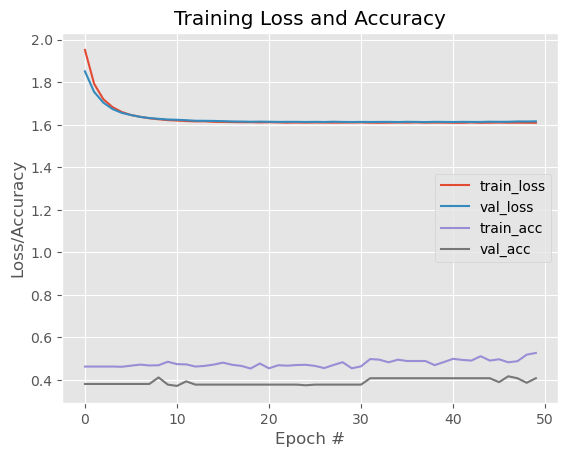

In [477]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
epoch_len = 50
plt.plot(np.arange(0, epoch_len), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_len), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epoch_len), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epoch_len), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Direct audio feed-in

In [ ]:
chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 44100  # Record at 44100 samples per second
seconds = 3
letters = string.ascii_lowercase

filename = 'wav_folder/' + ''.join(random.choice(letters) for i in range(10)) + '.wav'

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

In [ ]:
r = sr.Recognizer()
with sr.AudioFile(filename) as source:
    # listen for the data (load audio to memory)
    audio_data = r.record(source)
    # recognize (convert from speech to text)
    text = r.recognize_google(audio_data)
    print(text)

In [ ]:
X_test_lst, Y_test_lst = [], []

feature = get_features(filename)
for ele in feature:
    X_test_lst.append(ele)
    Y_test_lst.append(single_label)

X_test_lst = np.array(X_test_lst)

In [ ]:
X_test_lst = scaler.transform(X_test_lst)
X_test_lst = np.expand_dims(X_test_lst, axis=2)

In [ ]:
y_pred, pred_test

In [ ]:
# predicting on test data.
pred_test = model.predict(X_test_lst)
pred_test = np.array([pred_test[i:i+ 2].mean(axis = 0) for i in range(len(pred_test)//3)])
y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)

In [ ]:
#bert
bert_pred = pred_one(bert_model, text)
bert_pred

In [ ]:
labels

# generate data with code below

In [ ]:
chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 44100  # Record at 44100 samples per second
seconds = 5
letters = string.ascii_lowercase

cur_file = 'arthur_joy_1_4.wav'
filename = 'text_tone_data/arthur/' + cur_file

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()